<center><img src='https://netacad.centralesupelec.fr/img/cs.jpg' width=200></center>

<h6><center>M.Sc. DSBA & AI</center></h6>
<h3><center>Ensemble learning from theory to practice</center></h3>

<h1>
<hr style=" border:none; height:3px;">
<center>Project: Effect of online product description on its sales</center>
<hr style=" border:none; height:3px;">
</h1>

<h7><center>Romain COLLEDANI | Theo COSTES | Jeremie FERON | Antoine GALLIER | Alexandra GAUTRON</center></h7>


#Introduction

This notebook contains the python code we created and used for the project. It consists in two parts:

- **Data Preprocessing**, where we retrieved the data and worked on it (mainly creating interesting features and dealing with feature engineering as well as missing values),
- **Models**, where we implemented, tried and compared different models for the classification task, and then selected the best one.

# Data Preprocessing

## Libraries

First, we import the libraries and components that we will use in this Data Preprocessing part.

In [ ]:
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from scipy.sparse import csr_matrix
import numpy as np
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('english') + stopwords.words("french")

import seaborn as sns
import matplotlib.pyplot as plt

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Mounting notebook and defining paths

We connect this notebook to our Google Drive in order to easily import the data.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

path = "/content/drive/MyDrive/COURSES/EL/Project/" # mount & adapt

file_name = "summer-products-with-rating-and-performance_2020-08.csv"

## Getting the data

We import the raw data that will be used in this project.

In [ ]:
df = pd.read_csv(path + file_name)

## Extracting features from textual data

The first feature engineering that we performed was to "transform" all the textual data in our dataframe into a single indicator (numerical feature) that gives information on how the product descriptions can impact the units sold.

First, some useful functions for this task are defined.

In [ ]:
"""
Functions to compute the impact of the product descriptions on the turnover.

Columns added:
  - turnover
  - title_clean
  - desc_impact
"""

# preprocessing
def compute_turnover(df):
    df["turnover"] = df["units_sold"] * df["price"]
    return df

def scale_turnover(df):
    sc = StandardScaler()
    turnover_scaled = sc.fit_transform(np.array(df["turnover"]).reshape(-1,1))
    return turnover_scaled

def preprocess_descriptions(df):
    df["title_clean"] = df["title"].apply(
        lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))
    df["title_clean"] = df["title_clean"].str.strip("/")
    df["title_clean"] = df["title_clean"].str.strip(".")
    return df

# computing metrics on descriptions
def tfidf(df):
    """
    Returns the tfidf matrix built from the full corpus.
    """
    tfidf_model = TfidfVectorizer()
    x = tfidf_model.fit_transform(df.title_clean.to_list())
    tfidf_matrix = csr_matrix.todense(x)
    return tfidf_matrix, tfidf_model

def get_word_importance(tfidf_matrix, turnover_scaled):
    """
    Compute word importance with respect to their tfidf score
    and the turnover of the products they describe.
    
    tf_idf(i,j) = score of word i in doc j
    T_j = turnover scaled of product j

    word_i_importance = SUM_j(tf_idf(i,j) * T_j)
    """
    #Concatenating TFIDF representations with scaled turnover
    tfidf_matrix = np.hstack((tfidf_matrix,turnover_scaled))

    #Computing word impact on the turnover : word impact = word_importance * Scaled_CA
    word_importance = np.zeros((1,tfidf_matrix.shape[1]-1))
    for i in range(tfidf_matrix.shape[1]-1):
        impact = 0
        for j in range(tfidf_matrix.shape[0]):
            impact += tfidf_matrix[j,i]*tfidf_matrix[j,-1]
        word_importance[0,i] = impact
    return word_importance

def compute_top_words(word_importance, tfidf_model, quantile= 0.99):
    """
    Visualise some of the top words for interpretability.
    Not added to the dataset.
    """
    #Retrieving 10 words with biggest impact    
    treshold = np.quantile(word_importance,quantile)
    top_X_ids = np.where(word_importance>treshold)
    top_X = []
    for i in range(10):
        top_X.append(tfidf_model.get_feature_names()[top_X_ids[1][i]])
    return top_X

    
#Computing mean word_impact for each description
def mean_word_impact(title_clean, word_importance):
    """
    Returns the estimated impact of each product_desc on the product_turnover.

    desc_impact = 1/N * Sum( word_impact{word_i in product_desc})
    """
    cv_titles = CountVectorizer().fit_transform(title_clean)
    desc_length = np.sum(csr_matrix.todense(cv_titles),axis=1)
    desc_impact = np.matmul(csr_matrix.todense(cv_titles),word_importance.T)/desc_length
    return desc_impact

With these defined functions, we are now able to compute this "impact" feature and add it to our dataset.

In [ ]:
"""
Apply successively the functions defined above:
1. General preprocessing (deleting stuff)
2. Product_desc preprocessing (adding stuff)
3. Encoding of categorical features. 
"""
"""
Functions to compute the impact of the product descriptions on the turnover

Columns added:
  - turnover
  - title_clean
  - desc_impact
"""

# product_desc impact
df = compute_turnover(df)
turnover_scaled = scale_turnover(df)
df = preprocess_descriptions(df)
tfidf_matrix, tfidf_model = tfidf(df)
word_importance = get_word_importance(tfidf_matrix, turnover_scaled)
top_words = compute_top_words(word_importance, tfidf_model, quantile= 0.99)
# final feature we can use
desc_impact = mean_word_impact(df.title_clean.to_list(), word_importance)
df["product_desc_impact"] = desc_impact

Some visualisation to see how the new feature is distributed:

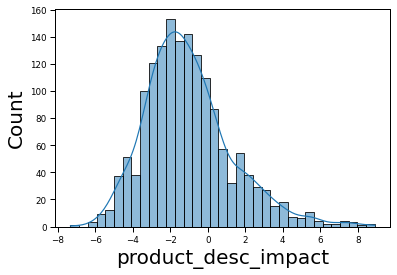

In [ ]:
sns.histplot(df['product_desc_impact'], kde=True)

## Deleting columns with same value for all rows

Next, we remove from our dataset the useless features that take only one value over the whole dataset.

In [ ]:
dict_col = {}
for feature in df.columns :
    dict_col[feature] = len(df[feature].unique())

In [ ]:
features_one_category = []
for feature, number_of_categories in dict_col.items():
    if number_of_categories == 1:
        features_one_category.append(feature)

In [ ]:
df = df.drop(features_one_category, axis=1)

## Deleting columns with urls

We also remove the features consisting in URLs, that will not be useful here for our task.

In [ ]:
url_features = ['merchant_id', 'merchant_profile_picture', 'product_url', 'product_picture','product_id']

df = df.drop(url_features, axis=1)

## Transforming some categorical features

Then, we deal with the categorical features that are in our dataset, mainly products' color and size.

We first decrease their value range by grouping some subcategories and then encode them so that they can directly be used by our models afterwards.

### First dealing with product color

In [ ]:
original_color = df['product_color']

In [ ]:
count = df['product_color'].value_counts()
count

black          302
white          254
yellow         105
blue            99
pink            99
              ... 
whitestripe      1
gold             1
army green       1
denimblue        1
blackwhite       1
Name: product_color, Length: 101, dtype: int64

In [ ]:
np.sort(df['product_color'].dropna().unique())


array(['Army green', 'Black', 'Blue', 'Pink', 'RED', 'Rose red', 'White',
       'applegreen', 'apricot', 'army', 'army green', 'armygreen',
       'beige', 'black', 'black & blue', 'black & green',
       'black & stripe', 'black & white', 'black & yellow', 'blackwhite',
       'blue', 'blue & pink', 'brown', 'brown & yellow', 'burgundy',
       'camel', 'camouflage', 'claret', 'coffee', 'coolblack', 'coralred',
       'darkblue', 'darkgreen', 'denimblue', 'dustypink', 'floral',
       'fluorescentgreen', 'gold', 'gray', 'gray & white', 'green',
       'grey', 'greysnakeskinprint', 'ivory', 'jasper', 'khaki',
       'lakeblue', 'leopard', 'leopardprint', 'light green', 'lightblue',
       'lightgray', 'lightgreen', 'lightgrey', 'lightkhaki', 'lightpink',
       'lightpurple', 'lightred', 'lightyellow', 'mintgreen',
       'multicolor', 'navy', 'navy blue', 'navyblue', 'navyblue & white',
       'nude', 'offblack', 'offwhite', 'orange', 'orange & camouflage',
       'orange-red', 'pink

Here we can see that there are too many differents colours and a majority of blacks and whites, we could combine different shades of a colour in order to balance a bit more the values and reduce the sparsity of the feature.

In [ ]:
df['product_color_preprocessed'] = df['product_color'].str.lower()
df[df['product_color'].str.contains('&', na=False)]['product_color'].unique()

array(['red & blue', 'blue & pink', 'white & green', 'black & green',
       'orange & camouflage', 'pink & black', 'pink & grey',
       'black & white', 'white & black', 'pink & white', 'pink & blue',
       'black & stripe', 'gray & white', 'brown & yellow',
       'winered & yellow', 'navyblue & white', 'white & red',
       'black & yellow', 'black & blue'], dtype=object)

In [ ]:
shade_to_colour = {
    'navyblue': 'blue', 'lightblue': 'blue', 'skyblue': 'blue', 'lakeblue': 'blue', 'darkblue': 'blue', 'denimblue': 'blue', 'navy blue': 'blue', 'prussianblue': 'blue',
    'navy': 'blue',
    'armygreen': 'green', 'army green': 'green', 'fluorescentgreen': 'green', 'mintgreen': 'green', 'light green': 'green', 'lightgreen': 'green',
    'applegreen': 'green', 'darkgreen': 'green', 'army': 'green', 'khaki': 'green', 'lightkhaki': 'green',
    'lightyellow': 'yellow', 
    'winered': 'red', 'wine red': 'red', 'lightred': 'red', 'coralred': 'red', 'rose red': 'red', 'watermelonred': 'red', 'orange-red': 'red', 'rosered': 'red',
    'claret': 'red', 'burgundy': 'red', 
    'gray': 'grey', 'silver': 'grey','lightgray': 'grey', 'lightgrey': 'grey', 'greysnakeskinprint': 'grey',
    'coffee': 'brown', 'camel': 'brown', 'tan': 'brown', 
    'offwhite': 'white', 'ivory': 'white', 'nude': 'white',
    'lightpink': 'pink', 'dustypink':'pink', 'rosegold': 'pink',
    'lightpurple': 'purple', 'coolblack': 'black', 'apricot': 'orange', 'offblack': 'black'
}

def update_color(col):
    if shade_to_colour.get(col, False):
        return shade_to_colour.get(col)
    elif '&' in col:
        return 'dual'
    elif col in shade_to_colour.values():
        return col
    else:
        return 'other'

df['product_color_preprocessed'].replace(np.nan, 'others', inplace=True)

df['product_color_preprocessed'] = df.product_color_preprocessed.apply(update_color)

In [ ]:
count = df['product_color_preprocessed'].value_counts()
count

black     308
white     260
blue      164
green     151
red       144
pink      108
yellow    107
other     104
grey       87
purple     54
dual       40
orange     29
brown      17
Name: product_color_preprocessed, dtype: int64

No handles with labels found to put in legend.


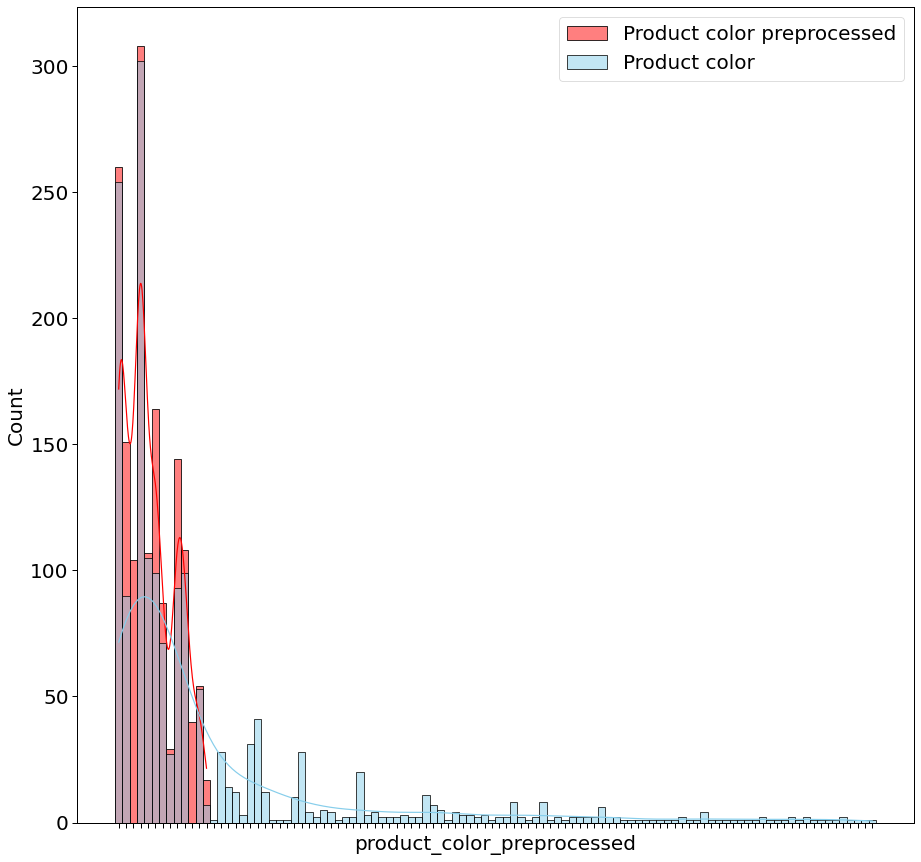

In [ ]:
sns.set_context("paper", rc={"font.size":20,"axes.titlesize":20,"axes.labelsize":20})   

fig, ax = plt.subplots(figsize=(15,15))
ax.legend(prop=dict(size=20))

for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(20)

for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(20)

sns.histplot(df['product_color_preprocessed'], color="red", label="Product color preprocessed", kde=True,ax=ax).set(xticklabels=[])
sns.histplot(df['product_color'].astype(str), color="skyblue", label="Product color", kde=True,ax=ax).set(xticklabels=[])

plt.legend(fontsize='medium')
plt.show()

In [ ]:
del df['product_color']

### *Then dealing with size*

We reproduce the same idea that was used for products' colors now for their size.

In [ ]:
df['product_variation_size_id'].unique()

array(['M', 'XS', 'S', 'Size-XS', 'M.', 'XXS', 'L', 'XXL', nan, 'S.', 's',
       'choose a size', 'XS.', '32/L', 'Suit-S', 'XXXXXL', 'EU 35', '4',
       'Size S.', '1m by 3m', '3XL', 'Size S', 'XL', 'Women Size 36',
       'US 6.5 (EU 37)', 'XXXS', 'SIZE XS', '26(Waist 72cm 28inch)',
       'Size XXS', '29', '1pc', '100 cm', 'One Size', 'SIZE-4XL', '1',
       'S/M(child)', '2pcs', 'XXXL', 'S..', '30 cm', '5XL', '33',
       'Size M', '100 x 100cm(39.3 x 39.3inch)', '100pcs', '2XL', '4XL',
       'SizeL', 'SIZE XXS', 'XXXXL', 'Base & Top & Matte Top Coat',
       'size S', '35', '34', 'SIZE-XXS', 'S(bust 88cm)',
       'S (waist58-62cm)', 'S(Pink & Black)', '20pcs', 'US-S',
       'Size -XXS', 'X   L', 'White', '25', 'Size-S', 'Round',
       'Pack of 1', '1 pc.', 'S Diameter 30cm', '6XL',
       'AU plug Low quality', '5PAIRS', '25-S', 'Size/S', 'S Pink',
       'Size-5XL', 'daughter 24M', '2', 'Baby Float Boat', '10 ml', '60',
       'Size-L', 'US5.5-EU35', '10pcs', '17', 'Size-XXS

Here again we see there are many differents values that could be grouped together.

In [ ]:
df['product_variation_size_id'].value_counts().head(20)

S          641
XS         356
M          200
XXS        100
L           49
S.          18
XL          17
XXL         15
XXXS         6
s            5
XS.          5
4XL          5
Size S       5
SIZE XS      4
Size-XS      4
2XL          4
M.           4
SizeL        3
33           3
34           3
Name: product_variation_size_id, dtype: int64

In [ ]:
df['product_variation_size_id_preprocessed'] = df['product_variation_size_id'].str.lower().str.replace('.', '').str.replace('size--', '').str.replace('size -', '').str.replace('size/', '').str.replace('size ', '').str.replace('size-', '')
df['product_variation_size_id'].unique()

array(['M', 'XS', 'S', 'Size-XS', 'M.', 'XXS', 'L', 'XXL', nan, 'S.', 's',
       'choose a size', 'XS.', '32/L', 'Suit-S', 'XXXXXL', 'EU 35', '4',
       'Size S.', '1m by 3m', '3XL', 'Size S', 'XL', 'Women Size 36',
       'US 6.5 (EU 37)', 'XXXS', 'SIZE XS', '26(Waist 72cm 28inch)',
       'Size XXS', '29', '1pc', '100 cm', 'One Size', 'SIZE-4XL', '1',
       'S/M(child)', '2pcs', 'XXXL', 'S..', '30 cm', '5XL', '33',
       'Size M', '100 x 100cm(39.3 x 39.3inch)', '100pcs', '2XL', '4XL',
       'SizeL', 'SIZE XXS', 'XXXXL', 'Base & Top & Matte Top Coat',
       'size S', '35', '34', 'SIZE-XXS', 'S(bust 88cm)',
       'S (waist58-62cm)', 'S(Pink & Black)', '20pcs', 'US-S',
       'Size -XXS', 'X   L', 'White', '25', 'Size-S', 'Round',
       'Pack of 1', '1 pc.', 'S Diameter 30cm', '6XL',
       'AU plug Low quality', '5PAIRS', '25-S', 'Size/S', 'S Pink',
       'Size-5XL', 'daughter 24M', '2', 'Baby Float Boat', '10 ml', '60',
       'Size-L', 'US5.5-EU35', '10pcs', '17', 'Size-XXS

In [ ]:
df['product_variation_size_id_preprocessed'] = df['product_variation_size_id_preprocessed'].replace('2xl', 'xxl')
df['product_variation_size_id_preprocessed'] = df['product_variation_size_id_preprocessed'].replace('3xl', 'xxxl')
df['product_variation_size_id_preprocessed'] = df['product_variation_size_id_preprocessed'].replace('4xl', 'xxxxl')
df['product_variation_size_id_preprocessed'] = df['product_variation_size_id_preprocessed'].replace('5xl', 'xxxxxl')
df['product_variation_size_id_preprocessed'] = df['product_variation_size_id_preprocessed'].replace('6xl', 'xxxxxxl')
df['product_variation_size_id_preprocessed'] = df['product_variation_size_id_preprocessed'].replace('x   l', 'xl')
df['product_variation_size_id_preprocessed'] = df['product_variation_size_id_preprocessed'].replace('sizel', 'l')
df['product_variation_size_id_preprocessed'] = df['product_variation_size_id_preprocessed'].replace('size4xl', 'xxxxl')
df['product_variation_size_id_preprocessed'] = df['product_variation_size_id_preprocessed'].replace('x   l', 'xl')
df['product_variation_size_id_preprocessed'] = df['product_variation_size_id_preprocessed'].replace('1 pc - xl', 'xl')

In [ ]:
def change_size(cl):
    if cl in 'xl,l,s,xs,m,xxl,xxs,xxxxl,xxxl'.split(','):
        return cl
    else:
        return 'other'

df['product_variation_size_id_preprocessed'] = df['product_variation_size_id_preprocessed'].replace(np.nan, 'OTHER')
df['product_variation_size_id_preprocessed'] = df['product_variation_size_id_preprocessed'].apply(change_size)

No handles with labels found to put in legend.


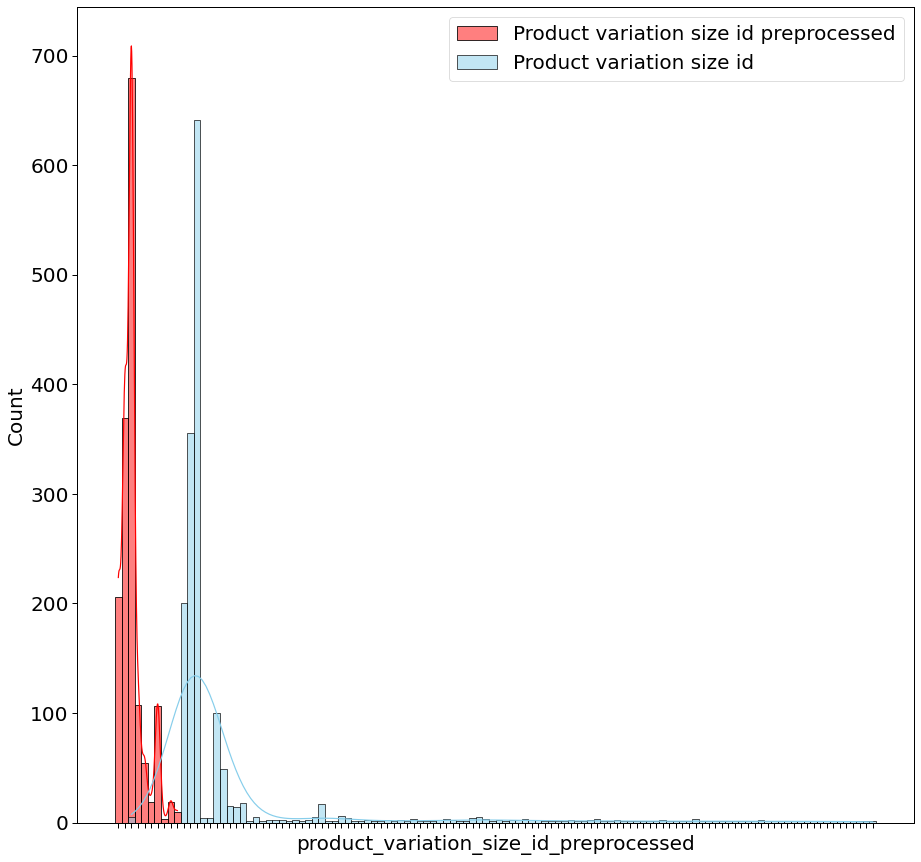

In [ ]:
sns.set_context("paper", rc={"font.size":20,"axes.titlesize":20,"axes.labelsize":20})   

fig, ax = plt.subplots(figsize=(15,15))
ax.legend(prop=dict(size=20))

for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(20)

for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(20)

sns.histplot(df['product_variation_size_id_preprocessed'], color="red", label="Product variation size id preprocessed", kde=True,ax=ax).set(xticklabels=[])
sns.histplot(df['product_variation_size_id'].astype(str), color="skyblue", label="Product variation size id", kde=True,ax=ax).set(xticklabels=[])

plt.legend(fontsize='medium')
plt.show()

No handles with labels found to put in legend.


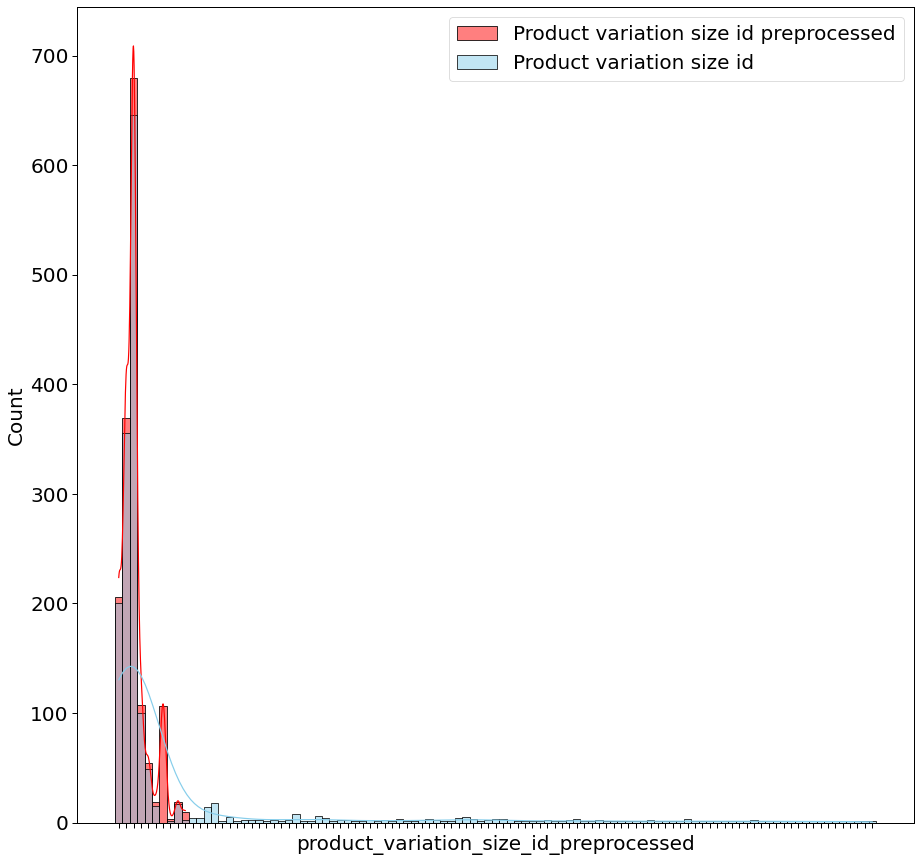

In [ ]:
sns.set_context("paper", rc={"font.size":20,"axes.titlesize":20,"axes.labelsize":20})   

fig, ax = plt.subplots(figsize=(15,15))
ax.legend(prop=dict(size=20))

for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(20)

for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(20)
sns.histplot(df['product_variation_size_id_preprocessed'].astype(str), color="red", label="Product variation size id preprocessed", kde=True,ax=ax).set(xticklabels=[])
sns.histplot(df['product_variation_size_id'].astype(str).str.lower(), color="skyblue", label="Product variation size id", kde=True,ax=ax).set(xticklabels=[])

plt.legend(fontsize='medium')
plt.show()

In [ ]:
df['product_color_preprocessed'].value_counts().head(50)

black     308
white     260
blue      164
green     151
red       144
pink      108
yellow    107
other     104
grey       87
purple     54
dual       40
orange     29
brown      17
Name: product_color_preprocessed, dtype: int64

In [ ]:
test = df[df['product_color_preprocessed'].isin(['black','white','blue','green','red'])]

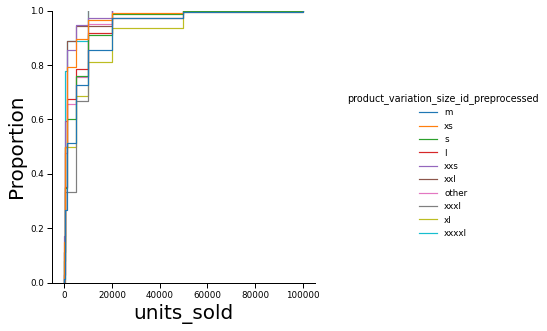

In [ ]:
sns.displot(test, x="units_sold",hue='product_variation_size_id_preprocessed' ,kind="ecdf")
plt.show()

In [ ]:
df['product_variation_size_id'].str.lower().value_counts().head(50)

s               646
xs              356
m               200
xxs             100
l                49
s.               18
xl               17
xxl              15
size s            8
xxxs              6
4xl               5
xs.               5
2xl               4
size-xs           4
m.                4
size xs           4
2pcs              3
33                3
size-xxs          3
sizel             3
10 ml             3
size-s            3
34                3
one size          2
eu 35             2
35                2
size xxs          2
xxxxxl            2
size s.           2
29                2
5xl               2
1                 2
size m            2
s(bust 88cm)      2
25                2
1 pc.             2
3xl               2
size4xl           2
size -xxs         2
xxxxl             2
s pink            2
suit-s            2
round             1
100 cm            1
size--s           1
20pcs             1
1pc               1
80 x 200 cm       1
white             1
1m by 3m          1


In [ ]:
del df['product_variation_size_id']

### Encoding categorical features

Now, we have to encode our categorical features that cannot be used as they are by our algorithms. To do so, we use the *get_dummies* function, that create dummy columns from our categorical features.

In [ ]:
categorical_features = ['shipping_option_name', 'origin_country', 'product_color_preprocessed', 'product_variation_size_id_preprocessed']

cat_df = pd.get_dummies(df[categorical_features])

In [ ]:
df = pd.concat([df, cat_df], axis = 1)
df = df.drop(categorical_features, axis=1)

## Removing useless columns

Finally, we remove the features that we won't use for solving our task (for instance, merchant's name and information subtitle).

Also, we notice that one column is redundant in our dataset: "rating_count" is the sum of the 5 columns "rating_five_count" + "rating_four_count" + "rating_three_count" + "rating_two_count" + "rating_one_count". Thus, it adds useless information and has to be removed.

In [ ]:
df = df.drop(['rating_count', 'merchant_name', 'merchant_info_subtitle'], axis=1)

## Dealing with missing values

Before fitting our algorithms, we have to deal with the features that contain missing values.

In [ ]:
df.columns[df.isna().any()].tolist()

['rating_five_count',
 'rating_four_count',
 'rating_three_count',
 'rating_two_count',
 'rating_one_count',
 'has_urgency_banner',
 'urgency_text']

In [ ]:
df.loc[:, df.isna().any()]

,rating_five_count,rating_four_count,rating_three_count,rating_two_count,rating_one_count,has_urgency_banner,urgency_text
0,26.0,8.0,10.0,1.0,9.0,1.0,Quantité limitée !
1,2269.0,1027.0,1118.0,644.0,1077.0,1.0,Quantité limitée !
2,5.0,4.0,2.0,0.0,3.0,1.0,Quantité limitée !
3,295.0,119.0,87.0,42.0,36.0,NaN,NaN
4,6.0,4.0,2.0,2.0,6.0,1.0,Quantité limitée !
...,...,...,...,...,...,...,...
1568,722.0,293.0,185.0,77.0,90.0,NaN,NaN
1569,11.0,3.0,1.0,3.0,10.0,1.0,Quantité limitée !
1570,24.0,15.0,8.0,3.0,9.0,NaN,NaN
1571,0.0,1.0,0.0,0.0,1.0,NaN,NaN


### Replace missing rating counts by 0

We notice that the ratings counts columns contain some missing values sometimes. We assume that these missing values correspond to absence of count and therefore replace the "NA" by a 0.

In [ ]:
for feature in ['rating_five_count', 'rating_four_count', 'rating_three_count',
                'rating_two_count', 'rating_one_count'] :
    df[feature] = df[feature].fillna(0)

### Dealing with "has_urgency_banner" and "urgency_text"

we also notice that the columns "has_urgency_banner" and "urgency_text" contains some missing value. Some more exploration of these 2 columns is needed in order to better understand where the missing values can come from.

In [ ]:
df['has_urgency_banner'].unique()

array([ 1., nan])

In [ ]:
df['urgency_text'].unique()

array(['Quantité limitée !', nan, 'Réduction sur les achats en gros'],
      dtype=object)

In [ ]:
df[['has_urgency_banner','urgency_text']]

,has_urgency_banner,urgency_text
0,1.0,Quantité limitée !
1,1.0,Quantité limitée !
2,1.0,Quantité limitée !
3,NaN,NaN
4,1.0,Quantité limitée !
...,...,...
1568,NaN,NaN
1569,1.0,Quantité limitée !
1570,NaN,NaN
1571,NaN,NaN


We now see that "has_urgency_banner" is always equal to 1, except when "urgency_text" is missing, so "has_urgency_banner" is useless.
"urgency_text" must be converted to a categorical feature :

In [ ]:
del df['has_urgency_banner']
df = pd.concat([df, pd.get_dummies(df['urgency_text'])], axis = 1)
del df['urgency_text']
df

,title,title_orig,price,retail_price,units_sold,uses_ad_boosts,rating,rating_five_count,rating_four_count,rating_three_count,rating_two_count,rating_one_count,badges_count,badge_local_product,badge_product_quality,badge_fast_shipping,tags,product_variation_inventory,shipping_option_price,shipping_is_express,countries_shipped_to,inventory_total,merchant_title,merchant_rating_count,merchant_rating,merchant_has_profile_picture,turnover,title_clean,product_desc_impact,shipping_option_name_Ekspresowa wysyłka,shipping_option_name_Envio Padrão,shipping_option_name_Envío normal,shipping_option_name_Expediere Standard,shipping_option_name_Livraison Express,shipping_option_name_Livraison standard,shipping_option_name_Spedizione standard,shipping_option_name_Standard Shipping,shipping_option_name_Standardowa wysyłka,shipping_option_name_Standardversand,shipping_option_name_Standart Gönderi,shipping_option_name_Стандартная доставка,shipping_option_name_الشحن القياسي,shipping_option_name_การส่งสินค้ามาตรฐาน,shipping_option_name_ការដឹកជញ្ជូនតាមស្តង់ដារ,origin_country_AT,origin_country_CN,origin_country_GB,origin_country_SG,origin_country_US,origin_country_VE,product_color_preprocessed_black,product_color_preprocessed_blue,product_color_preprocessed_brown,product_color_preprocessed_dual,product_color_preprocessed_green,product_color_preprocessed_grey,product_color_preprocessed_orange,product_color_preprocessed_other,product_color_preprocessed_pink,product_color_preprocessed_purple,product_color_preprocessed_red,product_color_preprocessed_white,product_color_preprocessed_yellow,product_variation_size_id_preprocessed_l,product_variation_size_id_preprocessed_m,product_variation_size_id_preprocessed_other,product_variation_size_id_preprocessed_s,product_variation_size_id_preprocessed_xl,product_variation_size_id_preprocessed_xs,product_variation_size_id_preprocessed_xxl,product_variation_size_id_preprocessed_xxs,product_variation_size_id_preprocessed_xxxl,product_variation_size_id_preprocessed_xxxxl,Quantité limitée !,Réduction sur les achats en gros
0,2020 Summer Vintage Flamingo Print Pajamas Se...,2020 Summer Vintage Flamingo Print Pajamas Se...,16.00,14,100,0,3.76,26.0,8.0,10.0,1.0,9.0,0,0,0,0,"Summer,Fashion,womenunderwearsuit,printedpajam...",50,4,0,34,50,zgrdejia,568,4.128521,0,1600.0,2020 Summer Vintage Flamingo Print Pajamas Set...,-2.449493,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0
1,SSHOUSE Summer Casual Sleeveless Soirée Party ...,Women's Casual Summer Sleeveless Sexy Mini Dress,8.00,22,20000,1,3.45,2269.0,1027.0,1118.0,644.0,1077.0,0,0,0,0,"Mini,womens dresses,Summer,Patchwork,fashion d...",50,2,0,41,50,SaraHouse,17752,3.899673,0,160000.0,SSHOUSE Summer Casual Sleeveless Soirée Party ...,2.697279,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
2,2020 Nouvelle Arrivée Femmes Printemps et Été ...,2020 New Arrival Women Spring and Summer Beach...,8.00,43,100,0,3.57,5.0,4.0,2.0,0.0,3.0,0,0,0,0,"Summer,cardigan,women beachwear,chiffon,Sexy w...",1,3,0,36,50,hxt520,295,3.989831,0,800.0,2020 Nouvelle Arrivée Femmes Printemps Été Pla...,-0.502368,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
3,Hot Summer Cool T-shirt pour les femmes Mode T...,Hot Summer Cool T Shirt for Women Fashion Tops...,8.00,8,5000,1,4.03,295.0,119.0,87.0,42.0,36.0,0,0,0,0,"Summer,Shorts,Cotton,Cotton T Shirt,Sleeve,pri...",50,2,0,41,50,allenfan,23832,4.020435,0,40000.0,Hot Summer Cool T-shirt femmes Mode Tops Abeil...,-2.050986,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
4,Femmes Shorts d'été à lacets taille élastique ...,Women Summer Shorts Lace Up Elastic Waistband ...,2.72,3,100,1,3.10,6.0,4.0,2.0,2.0,6.0,0,0,0,0,"Summer,Plus Size,Lace,Casual pants,Bottom,pant...",1,1,0,35,50,youngpeopleshop,14482,4.001588,0,272.0,Femmes Shorts d'été lacets taille élastique lâ...,-5.006563,0,0,0,0

## Creating new handcrafted features

We also wanted to create two new features that seemed to be relevant after our Data Analysis step:

In [ ]:
df["wish_discount"] = df.retail_price - df.price
df["diff_rating"] = df.rating - df.merchant_rating

## Transforming the target variable into a categorical feature

Finally, we grouped some classes of the target feature that contained a very few number of instances, so that the classes our algorithms will try to learn are a little bit more balanced.

In [ ]:
df['units_sold'].value_counts()

100       509
1000      405
5000      217
10000     177
20000     103
50         76
10         49
50000      17
100000      6
8           4
1           3
7           2
3           2
2           2
6           1
Name: units_sold, dtype: int64

In [ ]:
df['units_sold_cat'] = df['units_sold']

In [ ]:
df['units_sold_cat'].loc[df['units_sold'] < 100] = "<100"
df['units_sold_cat'].loc[df['units_sold'] > 10000] = "<10000"

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [ ]:
df['units_sold_cat'].value_counts()

100       509
1000      405
5000      217
10000     177
<100      139
<10000    126
Name: units_sold_cat, dtype: int64

In [ ]:
del df['units_sold']

In [ ]:
df = df.rename(columns={"units_sold_cat": "units_sold"})

So now, the problem is a multiclass classification problem, with 6 possible classes.

In [ ]:
df = df.drop(['title', 'title_orig', 'title_clean', 'tags', 'turnover', 'merchant_title'], axis=1)
df

,price,retail_price,uses_ad_boosts,rating,rating_five_count,rating_four_count,rating_three_count,rating_two_count,rating_one_count,badges_count,badge_local_product,badge_product_quality,badge_fast_shipping,product_variation_inventory,shipping_option_price,shipping_is_express,countries_shipped_to,inventory_total,merchant_title,merchant_rating_count,merchant_rating,merchant_has_profile_picture,product_desc_impact,shipping_option_name_Ekspresowa wysyłka,shipping_option_name_Envio Padrão,shipping_option_name_Envío normal,shipping_option_name_Expediere Standard,shipping_option_name_Livraison Express,shipping_option_name_Livraison standard,shipping_option_name_Spedizione standard,shipping_option_name_Standard Shipping,shipping_option_name_Standardowa wysyłka,shipping_option_name_Standardversand,shipping_option_name_Standart Gönderi,shipping_option_name_Стандартная доставка,shipping_option_name_الشحن القياسي,shipping_option_name_การส่งสินค้ามาตรฐาน,shipping_option_name_ការដឹកជញ្ជូនតាមស្តង់ដារ,origin_country_AT,origin_country_CN,origin_country_GB,origin_country_SG,origin_country_US,origin_country_VE,product_color_preprocessed_black,product_color_preprocessed_blue,product_color_preprocessed_brown,product_color_preprocessed_dual,product_color_preprocessed_green,product_color_preprocessed_grey,product_color_preprocessed_orange,product_color_preprocessed_other,product_color_preprocessed_pink,product_color_preprocessed_purple,product_color_preprocessed_red,product_color_preprocessed_white,product_color_preprocessed_yellow,product_variation_size_id_preprocessed_l,product_variation_size_id_preprocessed_m,product_variation_size_id_preprocessed_other,product_variation_size_id_preprocessed_s,product_variation_size_id_preprocessed_xl,product_variation_size_id_preprocessed_xs,product_variation_size_id_preprocessed_xxl,product_variation_size_id_preprocessed_xxs,product_variation_size_id_preprocessed_xxxl,product_variation_size_id_preprocessed_xxxxl,Quantité limitée !,Réduction sur les achats en gros,wish_discount,diff_rating,units_sold
0,16.00,14,0,3.76,26.0,8.0,10.0,1.0,9.0,0,0,0,0,50,4,0,34,50,zgrdejia,568,4.128521,0,-2.449493,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,-2.00,-0.368521,100
1,8.00,22,1,3.45,2269.0,1027.0,1118.0,644.0,1077.0,0,0,0,0,50,2,0,41,50,SaraHouse,17752,3.899673,0,2.697279,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,14.00,-0.449673,<10000
2,8.00,43,0,3.57,5.0,4.0,2.0,0.0,3.0,0,0,0,0,1,3,0,36,50,hxt520,295,3.989831,0,-0.502368,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,35.00,-0.419831,100
3,8.00,8,1,4.03,295.0,119.0,87.0,42.0,36.0,0,0,0,0,50,2,0,41,50,allenfan,23832,4.020435,0,-2.050986,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0.00,0.009565,5000
4,2.72,3,1,3.10,6.0,4.0,2.0,2.0,6.0,0,0,0,0,1,1,0,35,50,youngpeopleshop,14482,4.001588,0,-5.006563,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0.28,-0.901588,100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1568,6.00,9,1,4.08,722.0,293.0,185.0,77.0,90.0,0,0,0,0,50,2,0,41,50,cxuelin99126,5316,4.224605,0,-2.254562,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,3.00,-0.144605,10000
1569,2.00,56,1,3.07,11.0,3.0,1.0,3.0,10.0,0,0,0,0,2,1,0,26,50,sell best quality goods,4435,3.696054,0,-3.895801,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,54.00,-0.626054,100
1570,5.00,19,0,3.71,24.0,15.0,8.0,3.0,9.0,0,0,0,0,15,2,0,11,50,shixueying,210,3.961905,0,-2.026540,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

## Saving to a csv file

We save the dataset in a csv file.

In [ ]:
df.to_csv(path + "data_training.csv", index=False)

# Models - Ensemble Methods

Now that the dataset is ready for the learning step, we define the models that we want to test, tune the hyperparameters, compare the performance of the different algorithms, and select the best one.

## Libraries

We import the elements that will be useful in this part.

In [ ]:
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, balanced_accuracy_score, roc_auc_score
from sklearn.model_selection import GridSearchCV

from sklearn import tree
from sklearn.ensemble import BaggingClassifier, GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression

import seaborn as sns

## Data

We import the final dataset.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
path =  "/content/drive/MyDrive/EL/Project/"

filename = "data_training.csv"
#df = pd.read_csv(path + filename)
df = pd.read_csv('data_training_22mars.csv')
df.head()

,price,retail_price,uses_ad_boosts,rating,rating_five_count,rating_four_count,rating_three_count,rating_two_count,rating_one_count,badges_count,badge_local_product,badge_product_quality,badge_fast_shipping,product_variation_inventory,shipping_option_price,shipping_is_express,countries_shipped_to,inventory_total,merchant_title,merchant_rating_count,merchant_rating,merchant_has_profile_picture,product_desc_impact,shipping_option_name_Ekspresowa wysyłka,shipping_option_name_Envio Padrão,shipping_option_name_Envío normal,shipping_option_name_Expediere Standard,shipping_option_name_Livraison Express,shipping_option_name_Livraison standard,shipping_option_name_Spedizione standard,shipping_option_name_Standard Shipping,shipping_option_name_Standardowa wysyłka,shipping_option_name_Standardversand,shipping_option_name_Standart Gönderi,shipping_option_name_Стандартная доставка,shipping_option_name_الشحن القياسي,shipping_option_name_การส่งสินค้ามาตรฐาน,shipping_option_name_ការដឹកជញ្ជូនតាមស្តង់ដារ,origin_country_AT,origin_country_CN,origin_country_GB,origin_country_SG,origin_country_US,origin_country_VE,product_color_preprocessed_black,product_color_preprocessed_blue,product_color_preprocessed_brown,product_color_preprocessed_dual,product_color_preprocessed_green,product_color_preprocessed_grey,product_color_preprocessed_orange,product_color_preprocessed_other,product_color_preprocessed_pink,product_color_preprocessed_purple,product_color_preprocessed_red,product_color_preprocessed_white,product_color_preprocessed_yellow,product_variation_size_id_preprocessed_l,product_variation_size_id_preprocessed_m,product_variation_size_id_preprocessed_other,product_variation_size_id_preprocessed_s,product_variation_size_id_preprocessed_xl,product_variation_size_id_preprocessed_xs,product_variation_size_id_preprocessed_xxl,product_variation_size_id_preprocessed_xxs,product_variation_size_id_preprocessed_xxxl,product_variation_size_id_preprocessed_xxxxl,Quantité limitée !,Réduction sur les achats en gros,wish_discount,diff_rating,units_sold
0,16.00,14,0,3.76,26.0,8.0,10.0,1.0,9.0,0,0,0,0,50,4,0,34,50,zgrdejia,568,4.128521,0,-2.449493,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,-2.00,-0.368521,100
1,8.00,22,1,3.45,2269.0,1027.0,1118.0,644.0,1077.0,0,0,0,0,50,2,0,41,50,SaraHouse,17752,3.899673,0,2.697279,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,14.00,-0.449673,<10000
2,8.00,43,0,3.57,5.0,4.0,2.0,0.0,3.0,0,0,0,0,1,3,0,36,50,hxt520,295,3.989831,0,-0.502368,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,35.00,-0.419831,100
3,8.00,8,1,4.03,295.0,119.0,87.0,42.0,36.0,0,0,0,0,50,2,0,41,50,allenfan,23832,4.020435,0,-2.050986,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0.00,0.009565,5000
4,2.72,3,1,3.10,6.0,4.0,2.0,2.0,6.0,0,0,0,0,1,1,0,35,50,youngpeopleshop,14482,4.001588,0,-5.006563,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0.28,-0.901588,100


We define our target and dependent features, and split the dataset in a train dataset (80% of the original dataset) and a test dataset (remaining 20%).

The training set will be used for the hyperparameters tuning, and the test set will be used to compute the performance metrics and compare the different models.

In [ ]:
X = df[df.columns[:-1]]
y = df['units_sold']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [ ]:
X_train = X_train.drop(['merchant_title'],axis=1)
X_test = X_test.drop(['merchant_title'],axis=1)

## Useful functions

We define some functions that will be useful in the next steps:

- **grid_search** takes as input a model and a grid of parameters and performs a hyperparameters tuning (5-fold cross validated gridsearch) on the train set,

- **metrics** takes as input a model and the test set and computes the performance metrics associated to this specific model on the test set.

In [ ]:
def grid_search(model, parameters):
    cv = GridSearchCV(model, parameters, n_jobs=1, scoring='f1_weighted', cv=5,verbose=10, return_train_score=True)
    cv.fit(X_train, y_train)
    print('Best parameters :', cv.best_params_)
    return cv

In [ ]:
def metrics(model, X_test, y_test):
    y_pred = model.predict(X_test)
    
    res = {'Accuracy' : balanced_accuracy_score(y_test, y_pred),
           'F1 Score - weighted' : f1_score(y_test, y_pred, average='weighted'),
           'F1 Score - macro' : f1_score(y_test, y_pred, average='macro')}
    
    print("Scores :", res)    

    return res

We initialise a dictionary that will be filled step by step and will contain the performance metrics associated to each model.

In [ ]:
models = dict({})

## Models

In this part, we define the different models that we want to try and compare:

- Decision Tree
- Bagging
- Random Forest
- Extremely Randomized Trees
- Gradient Boosting
- AdaBoost
- XGBoost
- Stacking

Each model section follows the same logic: we define the parameters grid that will be used for the hyperparameters tuning, we perform the grid search to determine the optimal hyperparameters, then we fit the corresponding better model on the train set and finally we compute (on the test set) the performance metrics and then store them in the dictionary.

### Decision Tree

In [ ]:
params = {'max_depth' : [5, 10, 15, 20],
          'min_samples_leaf' : [2, 3, 5, 10]}

cv = grid_search(tree.DecisionTreeClassifier(random_state=0), params)

clf_tree = tree.DecisionTreeClassifier(random_state=0, **cv.best_params_)
clf_tree.fit(X_train, y_train)

models['Decision Tree'] = metrics(clf_tree, X_test, y_test)

del cv

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] max_depth=5, min_samples_leaf=2 .................................
[CV]  max_depth=5, min_samples_leaf=2, score=(train=0.817, test=0.774), total=   0.0s
[CV] max_depth=5, min_samples_leaf=2 .................................
[CV]  max_depth=5, min_samples_leaf=2, score=(train=0.833, test=0.701), total=   0.0s
[CV] max_depth=5, min_samples_leaf=2 .................................
[CV]  max_depth=5, min_samples_leaf=2, score=(train=0.820, test=0.723), total=   0.0s
[CV] max_depth=5, min_samples_leaf=2 .................................
[CV]  max_depth=5, min_samples_leaf=2, score=(train=0.799, test=0.779), total=   0.0s
[CV] max_depth=5, min_samples_leaf=2 .................................
[CV]  max_depth=5, min_samples_leaf=2, score=(train=0.830, test=0.715), total=   0.0s
[CV] max_depth=5, min_samples_leaf=3 .................................
[CV]  max_depth=5, min_samples_leaf=3, score=(train=0.815, test=0.765), total=   0.

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.2s remaining:    0.0s


[CV]  max_depth=5, min_samples_leaf=3, score=(train=0.827, test=0.719), total=   0.0s
[CV] max_depth=5, min_samples_leaf=5 .................................
[CV]  max_depth=5, min_samples_leaf=5, score=(train=0.809, test=0.749), total=   0.0s
[CV] max_depth=5, min_samples_leaf=5 .................................
[CV]  max_depth=5, min_samples_leaf=5, score=(train=0.832, test=0.701), total=   0.0s
[CV] max_depth=5, min_samples_leaf=5 .................................
[CV]  max_depth=5, min_samples_leaf=5, score=(train=0.815, test=0.720), total=   0.0s
[CV] max_depth=5, min_samples_leaf=5 .................................
[CV]  max_depth=5, min_samples_leaf=5, score=(train=0.797, test=0.786), total=   0.0s
[CV] max_depth=5, min_samples_leaf=5 .................................
[CV]  max_depth=5, min_samples_leaf=5, score=(train=0.818, test=0.716), total=   0.0s
[CV] max_depth=5, min_samples_leaf=10 ................................
[CV]  max_depth=5, min_samples_leaf=10, score=(train=0.797

[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed:    2.0s finished


### Bagging

In [ ]:
params = {'max_samples': [0.2, 0.4, 0.6, 0.8],
          'max_features': [0.2, 0.4, 0.6, 0.8]}

cv = grid_search(BaggingClassifier(random_state=0), params)

clf_bag = BaggingClassifier(random_state=0, **cv.best_params_)
clf_bag.fit(X_train, y_train)

models['Bagging'] = metrics(clf_bag, X_test, y_test)

del cv

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] max_features=0.2, max_samples=0.2 ...............................
[CV]  max_features=0.2, max_samples=0.2, score=(train=0.812, test=0.759), total=   0.0s
[CV] max_features=0.2, max_samples=0.2 ...............................
[CV]  max_features=0.2, max_samples=0.2, score=(train=0.825, test=0.738), total=   0.0s
[CV] max_features=0.2, max_samples=0.2 ...............................
[CV]  max_features=0.2, max_samples=0.2, score=(train=0.827, test=0.716), total=   0.0s
[CV] max_features=0.2, max_samples=0.2 ...............................
[CV]  max_features=0.2, max_samples=0.2, score=(train=0.825, test=0.737), total=   0.0s
[CV] max_features=0.2, max_samples=0.2 ...............................
[CV]  max_features=0.2, max_samples=0.2, score=(train=0.837, test=0.753), total=   0.0s
[CV] max_features=0.2, max_samples=0.4 ...............................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.2s remaining:    0.0s


[CV]  max_features=0.2, max_samples=0.4, score=(train=0.892, test=0.744), total=   0.0s
[CV] max_features=0.2, max_samples=0.4 ...............................
[CV]  max_features=0.2, max_samples=0.4, score=(train=0.915, test=0.741), total=   0.0s
[CV] max_features=0.2, max_samples=0.4 ...............................
[CV]  max_features=0.2, max_samples=0.4, score=(train=0.906, test=0.714), total=   0.0s
[CV] max_features=0.2, max_samples=0.4 ...............................
[CV]  max_features=0.2, max_samples=0.4, score=(train=0.908, test=0.737), total=   0.0s
[CV] max_features=0.2, max_samples=0.4 ...............................
[CV]  max_features=0.2, max_samples=0.4, score=(train=0.892, test=0.735), total=   0.0s
[CV] max_features=0.2, max_samples=0.6 ...............................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.4s remaining:    0.0s


[CV]  max_features=0.2, max_samples=0.6, score=(train=0.941, test=0.810), total=   0.0s
[CV] max_features=0.2, max_samples=0.6 ...............................
[CV]  max_features=0.2, max_samples=0.6, score=(train=0.949, test=0.746), total=   0.0s
[CV] max_features=0.2, max_samples=0.6 ...............................
[CV]  max_features=0.2, max_samples=0.6, score=(train=0.955, test=0.755), total=   0.0s
[CV] max_features=0.2, max_samples=0.6 ...............................
[CV]  max_features=0.2, max_samples=0.6, score=(train=0.956, test=0.769), total=   0.0s
[CV] max_features=0.2, max_samples=0.6 ...............................
[CV]  max_features=0.2, max_samples=0.6, score=(train=0.950, test=0.776), total=   0.0s
[CV] max_features=0.2, max_samples=0.8 ...............................
[CV]  max_features=0.2, max_samples=0.8, score=(train=0.974, test=0.795), total=   0.0s
[CV] max_features=0.2, max_samples=0.8 ...............................
[CV]  max_features=0.2, max_samples=0.8, score

[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed:    4.8s finished


### Random Forest

In [ ]:
params = {'n_estimators' : [500, 200, 300, 400],
          'max_depth' : [25, 10, 15, 20],
          'min_samples_leaf' : [1, 2, 3, 5, 10]}

cv = grid_search(RandomForestClassifier(random_state=0), params)

clf_rf = RandomForestClassifier(random_state=0, **cv.best_params_)
clf_rf.fit(X_train, y_train)

models['Random Forest'] = metrics(clf_rf, X_test, y_test)

del cv

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] max_depth=15, min_samples_leaf=1, n_estimators=500 ..............


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  max_depth=15, min_samples_leaf=1, n_estimators=500, score=(train=1.000, test=0.808), total=   1.3s
[CV] max_depth=15, min_samples_leaf=1, n_estimators=500 ..............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.4s remaining:    0.0s


[CV]  max_depth=15, min_samples_leaf=1, n_estimators=500, score=(train=1.000, test=0.767), total=   1.3s
[CV] max_depth=15, min_samples_leaf=1, n_estimators=500 ..............


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.9s remaining:    0.0s


[CV]  max_depth=15, min_samples_leaf=1, n_estimators=500, score=(train=1.000, test=0.777), total=   1.3s
[CV] max_depth=15, min_samples_leaf=1, n_estimators=500 ..............


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    4.3s remaining:    0.0s


[CV]  max_depth=15, min_samples_leaf=1, n_estimators=500, score=(train=1.000, test=0.832), total=   1.3s
[CV] max_depth=15, min_samples_leaf=1, n_estimators=500 ..............


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    5.8s remaining:    0.0s


[CV]  max_depth=15, min_samples_leaf=1, n_estimators=500, score=(train=1.000, test=0.800), total=   1.3s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    7.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    7.2s finished


Best parameters : {'max_depth': 15, 'min_samples_leaf': 1, 'n_estimators': 500}
Scores : {'Accuracy': 0.7470526454288984, 'F1 Score - weighted': 0.7854201887750124, 'F1 Score - macro': 0.76753969386463}


### Extremely Randomized Trees

In [ ]:
params = {'n_estimators' : [500, 200, 300, 400],
          'max_depth' : [25, 10, 15, 20],
          'min_samples_leaf' : [1, 2, 3, 5, 10]}

cv = grid_search(ExtraTreesClassifier(random_state=0), params)

clf_etc = ExtraTreesClassifier(random_state=0, **cv.best_params_)
clf_etc.fit(X_train, y_train)

models['Extra Trees'] = metrics(clf_etc, X_test, y_test)

del cv

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] max_depth=25, min_samples_leaf=1, n_estimators=300 ..............


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  max_depth=25, min_samples_leaf=1, n_estimators=300, score=(train=1.000, test=0.821), total=   0.6s
[CV] max_depth=25, min_samples_leaf=1, n_estimators=300 ..............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s remaining:    0.0s


[CV]  max_depth=25, min_samples_leaf=1, n_estimators=300, score=(train=1.000, test=0.774), total=   0.6s
[CV] max_depth=25, min_samples_leaf=1, n_estimators=300 ..............


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.4s remaining:    0.0s


[CV]  max_depth=25, min_samples_leaf=1, n_estimators=300, score=(train=1.000, test=0.790), total=   0.6s
[CV] max_depth=25, min_samples_leaf=1, n_estimators=300 ..............


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    2.1s remaining:    0.0s


[CV]  max_depth=25, min_samples_leaf=1, n_estimators=300, score=(train=1.000, test=0.822), total=   0.6s
[CV] max_depth=25, min_samples_leaf=1, n_estimators=300 ..............


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    2.8s remaining:    0.0s


[CV]  max_depth=25, min_samples_leaf=1, n_estimators=300, score=(train=1.000, test=0.788), total=   0.6s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    3.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    3.5s finished


Best parameters : {'max_depth': 25, 'min_samples_leaf': 1, 'n_estimators': 300}
Scores : {'Accuracy': 0.7199475096792235, 'F1 Score - weighted': 0.7624246880174953, 'F1 Score - macro': 0.7397927263096947}


### Gradient Boosting

In [ ]:
params = {'learning_rate' : [0.0001, 0.001, 0.01, 0.1],
          'n_estimators' : [100, 200, 300, 400],
          'max_depth' : [5, 10, 15, 20],
          'min_samples_leaf' : [2, 3, 5, 10]}

cv = grid_search(GradientBoostingClassifier(random_state=0), params)

clf_gb = GradientBoostingClassifier(random_state=0, **cv.best_params_)
clf_gb.fit(X_train, y_train)

models['Gradient Boosting'] = metrics(clf_gb, X_test, y_test)

del cv

Fitting 5 folds for each of 256 candidates, totalling 1280 fits
[CV] learning_rate=0.0001, max_depth=5, min_samples_leaf=2, n_estimators=100 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  learning_rate=0.0001, max_depth=5, min_samples_leaf=2, n_estimators=100, score=(train=0.170, test=0.170), total=   4.1s
[CV] learning_rate=0.0001, max_depth=5, min_samples_leaf=2, n_estimators=100 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.1s remaining:    0.0s


[CV]  learning_rate=0.0001, max_depth=5, min_samples_leaf=2, n_estimators=100, score=(train=0.170, test=0.170), total=   4.2s
[CV] learning_rate=0.0001, max_depth=5, min_samples_leaf=2, n_estimators=100 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    8.3s remaining:    0.0s


[CV]  learning_rate=0.0001, max_depth=5, min_samples_leaf=2, n_estimators=100, score=(train=0.170, test=0.170), total=   4.2s
[CV] learning_rate=0.0001, max_depth=5, min_samples_leaf=2, n_estimators=100 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   12.6s remaining:    0.0s


[CV]  learning_rate=0.0001, max_depth=5, min_samples_leaf=2, n_estimators=100, score=(train=0.170, test=0.171), total=   4.3s
[CV] learning_rate=0.0001, max_depth=5, min_samples_leaf=2, n_estimators=100 


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   16.9s remaining:    0.0s


[CV]  learning_rate=0.0001, max_depth=5, min_samples_leaf=2, n_estimators=100, score=(train=0.170, test=0.168), total=   4.1s
[CV] learning_rate=0.0001, max_depth=5, min_samples_leaf=2, n_estimators=200 


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   21.0s remaining:    0.0s


[CV]  learning_rate=0.0001, max_depth=5, min_samples_leaf=2, n_estimators=200, score=(train=0.170, test=0.170), total=   8.6s
[CV] learning_rate=0.0001, max_depth=5, min_samples_leaf=2, n_estimators=200 


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   29.7s remaining:    0.0s


[CV]  learning_rate=0.0001, max_depth=5, min_samples_leaf=2, n_estimators=200, score=(train=0.170, test=0.170), total=   8.8s
[CV] learning_rate=0.0001, max_depth=5, min_samples_leaf=2, n_estimators=200 


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   38.5s remaining:    0.0s


[CV]  learning_rate=0.0001, max_depth=5, min_samples_leaf=2, n_estimators=200, score=(train=0.170, test=0.170), total=   8.9s
[CV] learning_rate=0.0001, max_depth=5, min_samples_leaf=2, n_estimators=200 


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   47.4s remaining:    0.0s


[CV]  learning_rate=0.0001, max_depth=5, min_samples_leaf=2, n_estimators=200, score=(train=0.170, test=0.171), total=   8.9s
[CV] learning_rate=0.0001, max_depth=5, min_samples_leaf=2, n_estimators=200 


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   56.3s remaining:    0.0s


[CV]  learning_rate=0.0001, max_depth=5, min_samples_leaf=2, n_estimators=200, score=(train=0.170, test=0.168), total=   8.6s
[CV] learning_rate=0.0001, max_depth=5, min_samples_leaf=2, n_estimators=300 
[CV]  learning_rate=0.0001, max_depth=5, min_samples_leaf=2, n_estimators=300, score=(train=0.170, test=0.170), total=  13.1s
[CV] learning_rate=0.0001, max_depth=5, min_samples_leaf=2, n_estimators=300 
[CV]  learning_rate=0.0001, max_depth=5, min_samples_leaf=2, n_estimators=300, score=(train=0.170, test=0.170), total=  13.4s
[CV] learning_rate=0.0001, max_depth=5, min_samples_leaf=2, n_estimators=300 
[CV]  learning_rate=0.0001, max_depth=5, min_samples_leaf=2, n_estimators=300, score=(train=0.170, test=0.170), total=  13.4s
[CV] learning_rate=0.0001, max_depth=5, min_samples_leaf=2, n_estimators=300 
[CV]  learning_rate=0.0001, max_depth=5, min_samples_leaf=2, n_estimators=300, score=(train=0.170, test=0.171), total=  13.6s
[CV] learning_rate=0.0001, max_depth=5, min_samples_leaf=2

[Parallel(n_jobs=1)]: Done 1280 out of 1280 | elapsed: 361.4min finished


Best parameters : {'learning_rate': 0.1, 'max_depth': 10, 'min_samples_leaf': 3, 'n_estimators': 100}
Scores : {'Accuracy': 0.6926778421222782, 'F1 Score - weighted': 0.7340691272828632, 'F1 Score - macro': 0.7122879399036894}


### Adaboost

In [ ]:
params = {'n_estimators': [100, 200, 300, 400],
          'learning_rate': [0.01, 0.05, 0.1, 1]}

cv = grid_search(AdaBoostClassifier(random_state=0), params)

clf_ada = AdaBoostClassifier(random_state=0, **cv.best_params_)
clf_ada.fit(X_train, y_train)

models['Adaboost'] = metrics(clf_ada, X_test, y_test)

del cv

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] learning_rate=0.01, n_estimators=100 ............................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  learning_rate=0.01, n_estimators=100, score=(train=0.509, test=0.511), total=   0.5s
[CV] learning_rate=0.01, n_estimators=100 ............................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s


[CV]  learning_rate=0.01, n_estimators=100, score=(train=0.527, test=0.502), total=   0.5s
[CV] learning_rate=0.01, n_estimators=100 ............................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.1s remaining:    0.0s


[CV]  learning_rate=0.01, n_estimators=100, score=(train=0.480, test=0.456), total=   0.5s
[CV] learning_rate=0.01, n_estimators=100 ............................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.6s remaining:    0.0s


[CV]  learning_rate=0.01, n_estimators=100, score=(train=0.505, test=0.521), total=   0.5s
[CV] learning_rate=0.01, n_estimators=100 ............................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    2.2s remaining:    0.0s


[CV]  learning_rate=0.01, n_estimators=100, score=(train=0.540, test=0.518), total=   0.5s
[CV] learning_rate=0.01, n_estimators=200 ............................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    2.7s remaining:    0.0s


[CV]  learning_rate=0.01, n_estimators=200, score=(train=0.177, test=0.170), total=   0.9s
[CV] learning_rate=0.01, n_estimators=200 ............................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    3.8s remaining:    0.0s


[CV]  learning_rate=0.01, n_estimators=200, score=(train=0.277, test=0.242), total=   0.9s
[CV] learning_rate=0.01, n_estimators=200 ............................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    4.9s remaining:    0.0s


[CV]  learning_rate=0.01, n_estimators=200, score=(train=0.177, test=0.164), total=   0.9s
[CV] learning_rate=0.01, n_estimators=200 ............................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    5.9s remaining:    0.0s


[CV]  learning_rate=0.01, n_estimators=200, score=(train=0.497, test=0.521), total=   0.9s
[CV] learning_rate=0.01, n_estimators=200 ............................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    7.0s remaining:    0.0s


[CV]  learning_rate=0.01, n_estimators=200, score=(train=0.188, test=0.183), total=   0.9s
[CV] learning_rate=0.01, n_estimators=300 ............................
[CV]  learning_rate=0.01, n_estimators=300, score=(train=0.177, test=0.164), total=   1.4s
[CV] learning_rate=0.01, n_estimators=300 ............................
[CV]  learning_rate=0.01, n_estimators=300, score=(train=0.123, test=0.114), total=   1.4s
[CV] learning_rate=0.01, n_estimators=300 ............................
[CV]  learning_rate=0.01, n_estimators=300, score=(train=0.177, test=0.164), total=   1.4s
[CV] learning_rate=0.01, n_estimators=300 ............................
[CV]  learning_rate=0.01, n_estimators=300, score=(train=0.463, test=0.477), total=   1.4s
[CV] learning_rate=0.01, n_estimators=300 ............................
[CV]  learning_rate=0.01, n_estimators=300, score=(train=0.188, test=0.178), total=   1.4s
[CV] learning_rate=0.01, n_estimators=400 ............................
[CV]  learning_rate=0.01, n_

[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed:  1.7min finished


Best parameters : {'learning_rate': 0.1, 'n_estimators': 400}
Scores : {'Accuracy': 0.34616090527721766, 'F1 Score - weighted': 0.397718716893185, 'F1 Score - macro': 0.29499514408025046}


### XGBoost

In [ ]:
import xgboost as xgb

params = {'max_depth': range (2, 10, 1),
          'n_estimators': range(60, 220, 40),
          'learning_rate': [0.1, 0.01, 0.05],
          'min_child_weight':range(1,6,2)}

xg_cl = xgb.XGBClassifier(objective= 'multi:softmax', num_class= len(y_train.unique()),)

cv = grid_search(xg_cl, params)

clf_xgb = xgb.XGBClassifier(objective= 'multi:softmax', num_class= len(y_train.unique()), **cv.best_params_)
clf_xgb.fit(X_train, y_train)

models['XGBoost'] = metrics(clf_xgb, X_test, y_test)

del cv

Fitting 5 folds for each of 288 candidates, totalling 1440 fits
[CV] learning_rate=0.1, max_depth=2, min_child_weight=1, n_estimators=60 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  learning_rate=0.1, max_depth=2, min_child_weight=1, n_estimators=60, score=(train=0.820, test=0.781), total=   0.7s
[CV] learning_rate=0.1, max_depth=2, min_child_weight=1, n_estimators=60 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s remaining:    0.0s


[CV]  learning_rate=0.1, max_depth=2, min_child_weight=1, n_estimators=60, score=(train=0.842, test=0.740), total=   0.5s
[CV] learning_rate=0.1, max_depth=2, min_child_weight=1, n_estimators=60 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.2s remaining:    0.0s


[CV]  learning_rate=0.1, max_depth=2, min_child_weight=1, n_estimators=60, score=(train=0.840, test=0.778), total=   0.5s
[CV] learning_rate=0.1, max_depth=2, min_child_weight=1, n_estimators=60 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.8s remaining:    0.0s


[CV]  learning_rate=0.1, max_depth=2, min_child_weight=1, n_estimators=60, score=(train=0.838, test=0.796), total=   0.5s
[CV] learning_rate=0.1, max_depth=2, min_child_weight=1, n_estimators=60 


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    2.4s remaining:    0.0s


[CV]  learning_rate=0.1, max_depth=2, min_child_weight=1, n_estimators=60, score=(train=0.831, test=0.737), total=   0.5s
[CV] learning_rate=0.1, max_depth=2, min_child_weight=1, n_estimators=100 


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    2.9s remaining:    0.0s


[CV]  learning_rate=0.1, max_depth=2, min_child_weight=1, n_estimators=100, score=(train=0.876, test=0.792), total=   0.9s
[CV] learning_rate=0.1, max_depth=2, min_child_weight=1, n_estimators=100 


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    3.8s remaining:    0.0s


[CV]  learning_rate=0.1, max_depth=2, min_child_weight=1, n_estimators=100, score=(train=0.880, test=0.741), total=   0.9s
[CV] learning_rate=0.1, max_depth=2, min_child_weight=1, n_estimators=100 


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    4.7s remaining:    0.0s


[CV]  learning_rate=0.1, max_depth=2, min_child_weight=1, n_estimators=100, score=(train=0.885, test=0.770), total=   0.9s
[CV] learning_rate=0.1, max_depth=2, min_child_weight=1, n_estimators=100 


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    5.7s remaining:    0.0s


[CV]  learning_rate=0.1, max_depth=2, min_child_weight=1, n_estimators=100, score=(train=0.883, test=0.793), total=   0.9s
[CV] learning_rate=0.1, max_depth=2, min_child_weight=1, n_estimators=100 


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    6.6s remaining:    0.0s


[CV]  learning_rate=0.1, max_depth=2, min_child_weight=1, n_estimators=100, score=(train=0.895, test=0.774), total=   0.9s
[CV] learning_rate=0.1, max_depth=2, min_child_weight=1, n_estimators=140 
[CV]  learning_rate=0.1, max_depth=2, min_child_weight=1, n_estimators=140, score=(train=0.906, test=0.796), total=   1.2s
[CV] learning_rate=0.1, max_depth=2, min_child_weight=1, n_estimators=140 
[CV]  learning_rate=0.1, max_depth=2, min_child_weight=1, n_estimators=140, score=(train=0.914, test=0.744), total=   1.2s
[CV] learning_rate=0.1, max_depth=2, min_child_weight=1, n_estimators=140 
[CV]  learning_rate=0.1, max_depth=2, min_child_weight=1, n_estimators=140, score=(train=0.916, test=0.780), total=   1.2s
[CV] learning_rate=0.1, max_depth=2, min_child_weight=1, n_estimators=140 
[CV]  learning_rate=0.1, max_depth=2, min_child_weight=1, n_estimators=140, score=(train=0.922, test=0.814), total=   1.2s
[CV] learning_rate=0.1, max_depth=2, min_child_weight=1, n_estimators=140 
[CV]  lear

[Parallel(n_jobs=1)]: Done 1440 out of 1440 | elapsed: 53.8min finished


Best parameters : {'learning_rate': 0.1, 'max_depth': 4, 'min_child_weight': 1, 'n_estimators': 100}
Scores : {'Accuracy': 0.7450441938557332, 'F1 Score - weighted': 0.7761896381555047, 'F1 Score - macro': 0.7611513049548897}


### Stacking 

In [ ]:
estimators = [('rf', RandomForestClassifier(n_estimators=500,max_depth=15,min_samples_leaf=1)),
              ('etc',ExtraTreesClassifier(n_estimators=300,max_depth=25,min_samples_leaf=1))]

clf_stack = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())
clf_stack.fit(X_train, y_train)
metrics(clf_stack, X_test, y_test)

Scores : {'Accuracy': 0.7477423123629511, 'F1 Score - weighted': 0.7775211944486273, 'F1 Score - macro': 0.763113557159392}


{'Accuracy': 0.7477423123629511,
 'F1 Score - macro': 0.763113557159392,
 'F1 Score - weighted': 0.7775211944486273}

## Final results and model selection

Now that we runned all the previous steps, we can take a look at the different metrics and select the best model (that has the highest score, here we consider the F1 weighted score).

In [ ]:
models

{'AdaBoost': {'Accuracy': 0.34616090527721766,
  'F1 Score - macro': 0.29499514408025046,
  'F1 Score - weighted': 0.397718716893185},
 'Bagging': {'Accuracy': 0.7092672836002948,
  'F1 Score - macro': 0.7315276089315331,
  'F1 Score - weighted': 0.7470843178151281},
 'Decision Tree': {'Accuracy': 0.6135956727789585,
  'F1 Score - macro': 0.6301565104714161,
  'F1 Score - weighted': 0.6525285128912917},
 'Extra Trees': {'Accuracy': 0.7199475096792235,
  'F1 Score - macro': 0.7397927263096947,
  'F1 Score - weighted': 0.7624246880174953},
 'Gradient Boosting': {'Accuracy': 0.6926778421222782,
  'F1 Score - macro': 0.7122879399036894,
  'F1 Score - weighted': 0.7340691272828632},
 'Random Forest': {'Accuracy': 0.7470526454288984,
  'F1 Score - macro': 0.76753969386463,
  'F1 Score - weighted': 0.7854201887750124},
 'Stacking': {'Accuracy': 0.7688071023699766,
  'F1 Score - macro': 0.7834975786592349,
  'F1 Score - weighted': 0.7994013262894769},
 'XGBoost': {'Accuracy': 0.745044193855733

We notice that the **Stacking** is the model that has the better performance across all the different considered metrics, this is therefore the chosen optimal method. Also, we can notice that the **XGBoost** performs almost equally well, as its associated performance metrics are very close.

## Interpretability

For the interpretability step, we wanted to try two different approaches: feature importances and Shapley values.

### Feature Importances

First we define our optimal method as being the Random Forest, and compute the feature importances for the 20 more important features.

In [ ]:
best_model = clf_rf

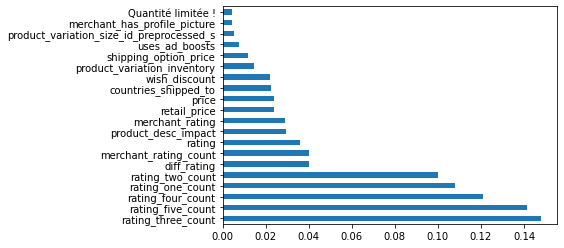

In [ ]:
feat_importances = pd.Series(best_model.feature_importances_, index=X.columns)
feat_importances.nlargest(20).plot(kind='barh')

We notice here that among the features that were the more important in the "units_sold" class prediction task, the **products' ratings** as well as **merchants' rating** were very important.

Also, we notice that our handcrafted features proved to be relevant (in particular, **diff_rating** and **product_desc_impact**).

### Shapley Values

Finally, we wanted to use the Shapley values to explain the relative importance of the best features in the classification task.

In [ ]:
pip install shap

In [ ]:
import shap

explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X)
shap.summary_plot(shap_values[1], X)

This summary plot is particularly useful to get indications of the relationship between the value of a feature and the impact on the prediction.

Here for instance we can notice that low merchant rating reduce the number of units sold and on the contrary, when some ad boosts are used, the number of units sold goes up.

# Conclusion

With this project, we were able to perform a classification task on the number of units sold for each product, given some dependent features.

We first created a data preprocessing step, that consisted in working on feature engineering, creating more relevant features, dealing with missing values as well as categorical features for instance.

Then we trained and compared different models and ensemble methods to perform the classification task. After computing some performance metrics, we were able to identify an optimal model (Stacking, closely followed by Random Forest and XGBoost).

In the end, we used Feature Importances and Shapley Values to interpret our model mechanism and outputs.